# Building powerful image classification models using very little data

http://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Training a small convnet from scratch: 80% accuracy in 40 lines of code

The right tool for an image classification job is a convnet, so let's try to train one on our data, as an initial baseline. Since we only have few examples, our number one concern should be overfitting. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Data augmentation is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Your main focus for fighting overfitting should be the entropic capacity of your model --how much information your model is allowed to store. A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features. Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better.

There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of weight regularization, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.

In our case we will use a very small convnet with few layers and few filters per layer, alongside data augmentation and dropout. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).

The code snippet below is our first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).

The full code for this experiment can be found [here](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d).

It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data

In our setup, we:
- created a **data/** folder
- created **train/** and **validation/** subfolders inside **data/**
- created **cats/** and **dogs/** subfolders inside **train/** and **validation/**
- put the cat pictures index 0-999 in **data/train/cats**
- put the cat pictures index 1000-1400 in **data/validation/cats**
- put the dogs pictures index 12500-13499 in **data/train/dogs**
- put the dog pictures index 13500-13900 in **data/validation/dogs**
So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```

---

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 20
batch_size = 16

In [3]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

On top of it we stick two fully-connected layers. We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. To go with it we will also use the binary_crossentropy loss to train our model.

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Let's prepare our data. We will use .flow_from_directory() to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

In [6]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


We can now use these generators to train our model. Each epoch takes 20-30s on GPU and 300-400s on CPU. So it's definitely viable to run this model on CPU if you aren't in a hurry.

In [7]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

Epoch 1/20
125/125 [==============================] - 22s - loss: 0.7306 - acc: 0.5175 - val_loss: 0.6747 - val_acc: 0.5162
Epoch 2/20
125/125 [==============================] - 19s - loss: 0.6818 - acc: 0.5870 - val_loss: 0.6486 - val_acc: 0.5938
Epoch 3/20
125/125 [==============================] - 19s - loss: 0.6378 - acc: 0.6290 - val_loss: 0.6088 - val_acc: 0.6763
Epoch 4/20
125/125 [==============================] - 19s - loss: 0.6159 - acc: 0.6570 - val_loss: 0.6081 - val_acc: 0.6575
Epoch 5/20
125/125 [==============================] - 19s - loss: 0.5956 - acc: 0.6920 - val_loss: 0.5734 - val_acc: 0.7037
Epoch 6/20
125/125 [==============================] - 18s - loss: 0.5751 - acc: 0.7170 - val_loss: 0.5499 - val_acc: 0.7150
Epoch 7/20
125/125 [==============================] - 18s - loss: 0.5637 - acc: 0.7105 - val_loss: 0.5351 - val_acc: 0.7338
Epoch 8/20
125/125 [==============================] - 19s - loss: 0.5491 - acc: 0.7290 - val_loss: 0.5291 - val_acc: 0.7325
Epoch 9/

In [9]:
# list all data in history
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

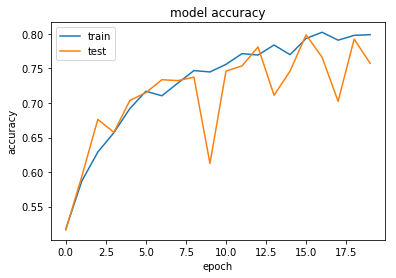

In [32]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

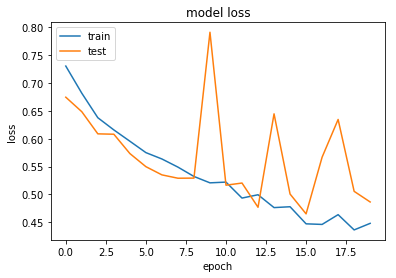

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

This approach gets us to a validation accuracy of 0.79-0.81 after 50 epochs (a number that was picked arbitrarily --because the model is small and uses aggressive dropout, it does not seem to be overfitting too much by that point). So at the time the Kaggle competition was launched, we would be already be "state of the art" --with 8% of the data, and no effort to optimize our architecture or hyperparameters. In fact, in the Kaggle competition, this model would have scored in the top 100 (out of 215 entrants). I guess that at least 115 entrants weren't using deep learning ;)

Note that the variance of the validation accuracy is fairly high, both because accuracy is a high-variance metric and because we only use 800 validation samples. A good validation strategy in such cases would be to do k-fold cross-validation, but this would require training k models for every evaluation round.